In [1]:
import numpy as np  
from support_functions import *
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


## Parameters

In [2]:
anomaly_digit = 2 # Set digit 2 as our anomaly
n_components=30 # 30 components in the encoded matrix
k = 50 # Define the k parameter for the precision at k

## Read Data

In [3]:
data_path = 'data/input_data/'
# Read image matrix (n*m), labels (vector of m), and image size
imgs_train, imgs_test, labels_train, labels_test, height, width = read_process_data(data_path, anomaly_digit)
# The length of one image vector
img_size = height*width 

### Load the Saved Models
#### Autoencoder Model

In [4]:
# Generate and Compile a Deep Autoencoder
# We will not use encoder in the Reconstruction Error Method
autoencoder, encoder = compile_autoencoder(img_size) 
autoencoder = load_model('model_autoencoder.h5') # Load the saved model

### Visualize the Reconstructed Image

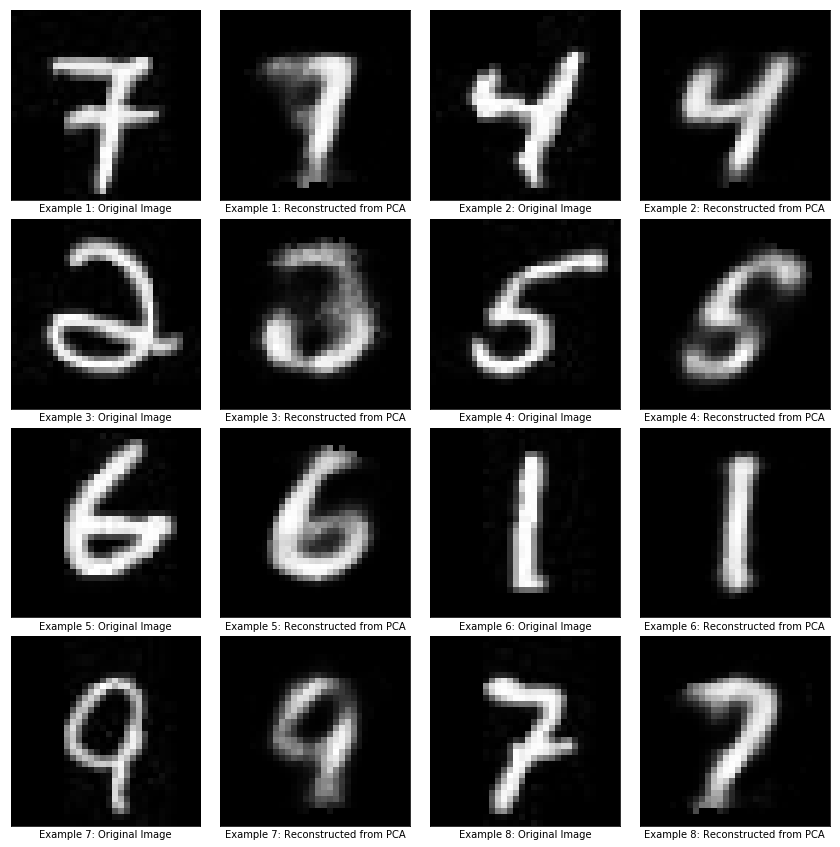

In [5]:
imgs = imgs_train.astype('float32') / 255. # Normalize the Data
# Load into the model and get the processed output
imgs_reconst = autoencoder.predict(imgs)

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(imgs_reconst,imgs_train,height,width)

## Implement the Anomaly Detection¶with Construction Error

### Reconstruct both training and testing data with Deep Autoencoder

In [6]:
# Normalize the Data
x_train = imgs_train.astype('float32') / 255. # Normalize the Data
x_test = imgs_test.astype('float32') / 255. # Normalize the Data

reconst_train = autoencoder.predict(x_train)
reconst_test = autoencoder.predict(x_test)

### Select the Threshold from the Training Dataset

The higher the reconstruction error, the more likely the point will be an anomaly


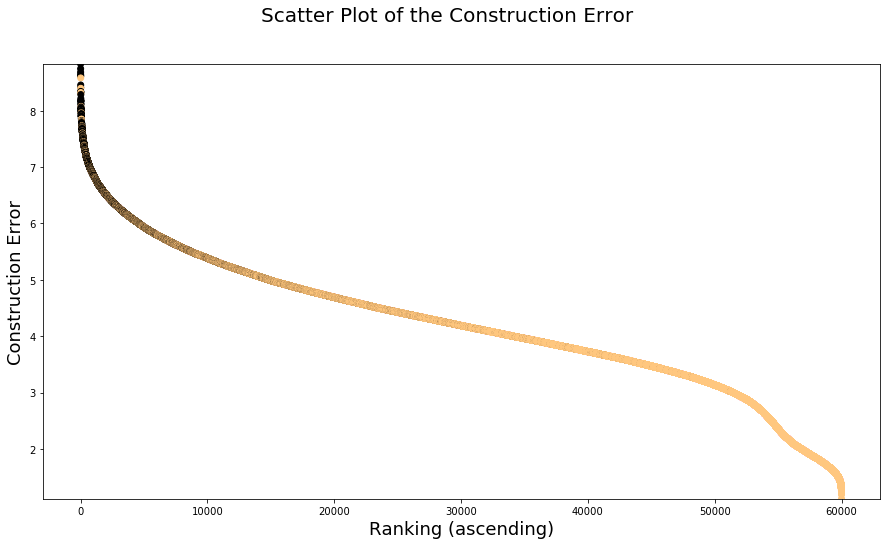

In [7]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_train = find_euclidean_distance(reconst_train,x_train)
print("The higher the reconstruction error, the more likely the point will be an anomaly")
plot_scatter_with_labels(dist_train,labels_train, 'Construction Error')

In [8]:
threshold_reconst_error = select_threshold_distance(dist_train, labels_train, k, to_print = True)

Precision: 45.0%
Recall: 66.0%
F-score: 53.5%
Precision@50: 82.0%


### Evaluate the Detector with the Testing Dataset

In [9]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_test = find_euclidean_distance(reconst_test,x_test)

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(-dist_test) # Sort from the Largest to the Smallest
dist_test_ranked = dist_test[rank_test] # Sort the distance
labels_test_ranked = labels_test[rank_test] # Rank Labels

# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[dist_test_ranked > threshold_reconst_error] = 1

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = k)

Precision: 46.8%
Recall: 62.4%
F-score: 53.5%
Precision@50: 86.0%
